have to give the reference of the DATASET link is here: http://idd.insaan.iiit.ac.in/dataset/download/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras.models import Model
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
import math
import time
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Tensorflow ver. {tf.__version__}')

Tensorflow ver. 2.17.1


In [ ]:
SEED = 42

# Dataset path
dataset_path = '.../idd20k_lite/'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'

img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'

Sample Training Image

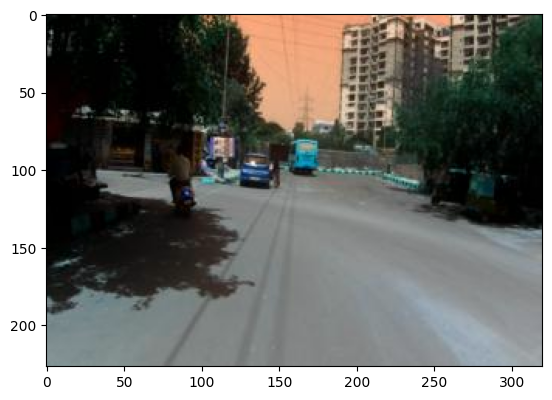

In [ ]:
# Reading a sample image and plotting it
img = cv2.imread(img_train+'29/972458_image.jpg',1)
plt.imshow(img)

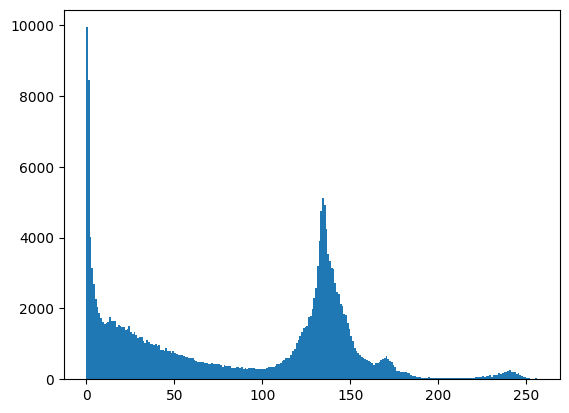

In [ ]:
# Plotting an Histogram to find the frequency of pixel intensity values.
plt.hist(img.ravel(),256,[0,256])
plt.show()

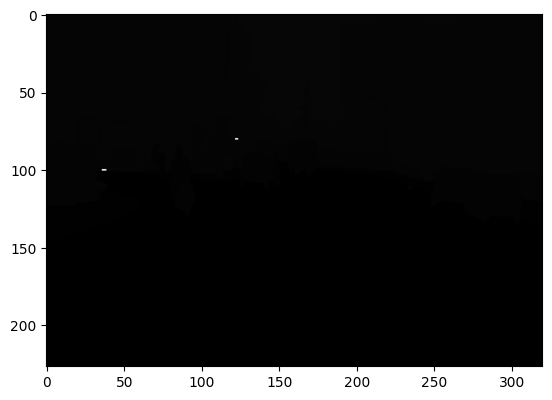

In [ ]:
# Reading the given annotated image for the above sample image
img = cv2.imread(seg_train+'29/972458_label.png',1)
plt.imshow(img)

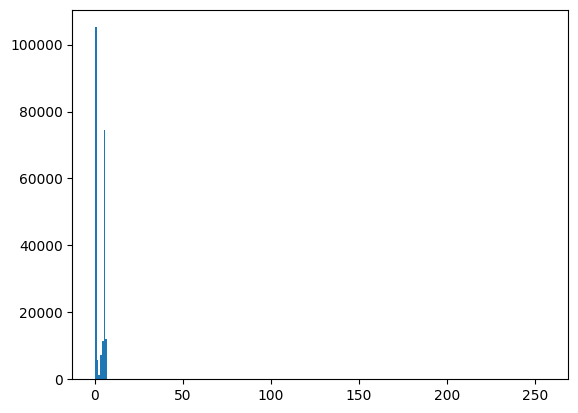

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img.ravel(),256,[0,256])
plt.show()

In [ ]:
# Frequency Distribution
# This is to find the exact number of pixels corresponind to each class
y = np.bincount(img.flatten())
ii = np.nonzero(y)[0]
np.vstack((ii, y[ii])).T

array([[     0, 105186],
       [     1,   5832],
       [     2,   1416],
       [     3,   7371],
       [     4,  11481],
       [     5,  74550],
       [     6,  12069],
       [   255,     15]])

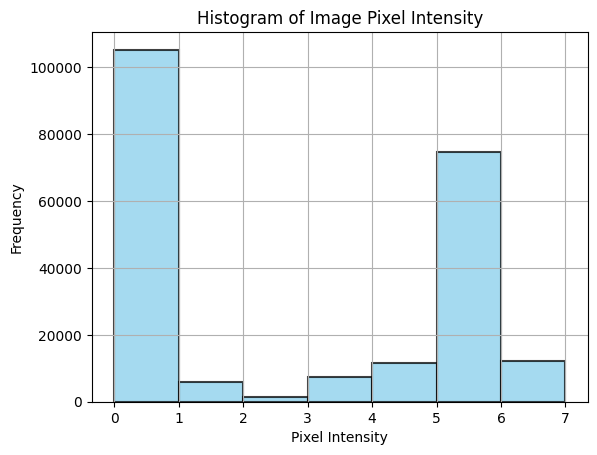

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
import matplotlib.pyplot as plt
plt.hist(img.ravel(), bins=7, range=[0,7], color='skyblue', edgecolor='black', alpha=0.75, linewidth=1.5)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Image Pixel Intensity')
plt.grid(True)
plt.show()

Plotting the annotated image after intensifying the pixels

In [ ]:
# This function visualizes the segmenetation image by multiplying each pixel with 40
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def visualizeSegmentationImages(imagepath):
    img_seg = cv2.imread(imagepath,0)
    # We are going to loop through all the pixel values and multiply them by 40 now
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if img_seg[i][j] != 0 or img_seg[i][j] != 255:
                # max value will be 6*40=240 which is under 255
                img_seg[i][j] *= 40
    return img_seg

In [ ]:
# Getting the processed segmentation image for visualization
img_seg = visualizeSegmentationImages(seg_train+'29/972458_label.png')

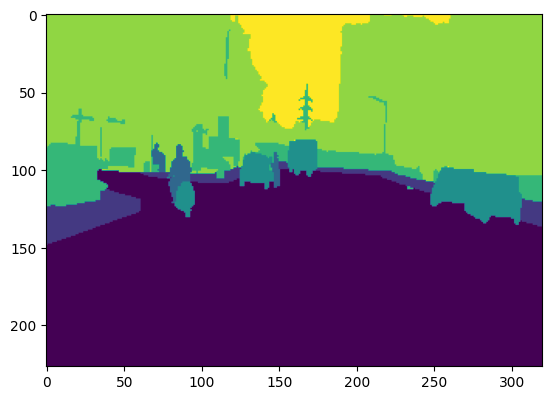

In [ ]:
# Plotting the processed segmentation image
plt.imshow(img_seg)

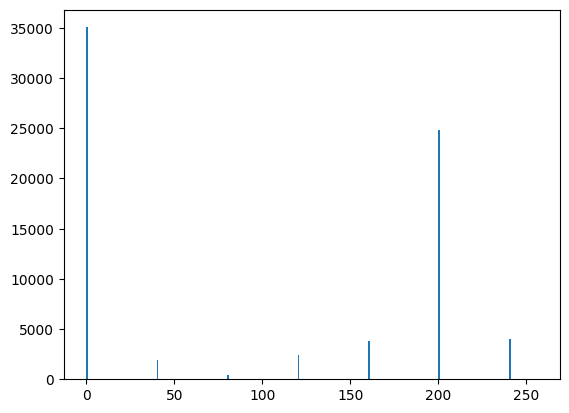

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img_seg.ravel(),256,[0,256])
plt.show()

Data Preparation

In [ ]:
"""# Image size that we are going to use
(HEIGHT,WIDTH) = (128,128)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 7 classes (0-6) + `not labeled`
N_CLASSES = 8"""


# Image size that we are going to use
(HEIGHT,WIDTH) = (128,128)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 8 classes (0-6) + `not labeled`
N_CLASSES = 8

In [ ]:
def parse_image(img_path):
    """
    Load an image and its annotation (mask) and returning a dictionary.
    """
    # Reading the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # For one Image path:
    # .../idd20k_lite/leftImg8bit/train/024541_image.jpg
    # Its corresponding annotation path is:
    # .../idd20k_lite/gtFine/train/024541_label.png
    mask_path = tf.strings.regex_replace(img_path, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    # Reading the annotation file corresponding the image file
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess with our N_CLASS = 7
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask==255, np.dtype('uint8').type(7), mask)
    # Note that we have to convert the new value (7)
    # With the same dtype than the tensor itself
    return {'image': image, 'segmentation_mask': mask}

In [ ]:
train_dataset = tf.data.Dataset.list_files(img_train+'*/*_image.jpg', seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(img_val+'*/*_image.jpg', seed=SEED)
val_dataset = val_dataset.map(parse_image)

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/cast
# Returns a Tensor same shape as given tensor and same type as dtype that is mentioned.

def normalize(input_image, input_mask):
    """
    Rescale the pixel values of the images between 0 and 1 compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
    """
    Normalize and resize a train image and its annotation.
    Apply random transformations to an input dictionary containing a train image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    """
    Normalize and resize a test image and its annotation.
    Since this is for the test set, we don't need to apply any data augmentation technique.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [ ]:
BATCH_SIZE = 8
BUFFER_SIZE = 1500
dataset = {"train": train_dataset, "val": val_dataset}

In [ ]:
# Preparing the Train dataset by applying dataset transformations
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)
print(dataset['train'])

# Preparing the Validation Dataset
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)
print(dataset['val'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


Visualizing after processing the data

In [ ]:
def display_sample(display_list):
    """
    Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


In [ ]:
# Getting a sample image for visualizing
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

In [ ]:

# Displaying a sample Input Image and its corresponding mask
display_sample([sample_image[0], sample_mask[0]])



Model Building (my-net)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, concatenate, Input, Activation
from tensorflow.keras.models import Model


def mynet_encode(input_tensor, filters, stack=4):
    x = BatchNormalization()(input_tensor)
    x = ReLU()(x)
    x = Conv2D(filters * stack, kernel_size=1, padding='same', use_bias=True)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=True)(x)
    return x


def mynet_encode3(input_tensor, filters, stack=3):
    x1 = mynet_encode(input_tensor, filters, stack)
    x2 = concatenate([input_tensor, x1])
    x3 = mynet_encode(x2, filters, stack)
    x4 = concatenate([x2, x3])
    x5 = mynet_encode(x4, filters, stack)
    output = concatenate([x4, x5])
    return BatchNormalization()(output)


def mynet_dense_framework2(input_shape=(128, 128, 3), filters=15):
    inputs = Input(shape=input_shape)

    # Encoder Layers
    conv1 = Conv2D(filters, kernel_size=3, strides=2, padding='same', use_bias=True)(inputs)
    conv1 = mynet_encode3(conv1, filters)
    conv1 = ReLU()(conv1)

    conv2 = Conv2D(4 * filters, kernel_size=3, strides=2, padding='same', use_bias=True)(conv1)
    conv2 = mynet_encode3(conv2, filters)
    conv2 = ReLU()(conv2)

    conv3 = Conv2D(7 * filters, kernel_size=3, strides=2, padding='same', use_bias=True)(conv2)
    conv3 = mynet_encode3(conv3, filters)
    conv3 = ReLU()(conv3)

    conv4 = Conv2D(13 * filters, kernel_size=3, strides=2, padding='same', use_bias=True)(conv3)
    conv4 = mynet_encode3(conv4, filters)
    conv4 = ReLU()(conv4)

    conv5 = Conv2D(25 * filters, kernel_size=3, strides=2, padding='same', use_bias=True)(conv4)
    conv5 = mynet_encode3(conv5, filters)
    conv5 = ReLU()(conv5)

    # Decoder Layers
    up1 = Conv2DTranspose(13 * filters, kernel_size=2, strides=2, use_bias=True)(conv5)
    up1 = concatenate([up1, conv4])
    up1 = BatchNormalization()(up1)
    up1 = ReLU()(up1)

    up2 = Conv2DTranspose(7 * filters, kernel_size=2, strides=2, use_bias=True)(up1)
    up2 = concatenate([up2, conv3])
    up2 = BatchNormalization()(up2)
    up2 = ReLU()(up2)

    up3 = Conv2DTranspose(filters, kernel_size=2, strides=2, use_bias=True)(up2)
    up3 = concatenate([up3, conv2])
    up3 = BatchNormalization()(up3)
    up3 = ReLU()(up3)

    up4 = Conv2DTranspose(filters, kernel_size=2, strides=2, use_bias=True)(up3)
    up4 = concatenate([up4, conv1])
    up4 = BatchNormalization()(up4)
    up4 = ReLU()(up4)

    up5 = Conv2DTranspose(filters, kernel_size=2, strides=2, use_bias=True)(up4)
    up5 = BatchNormalization()(up5)
    up5 = ReLU()(up5)

    # Final Layer
    outputs = Conv2D(filters=8, kernel_size=1, padding="same", activation="softmax")(up5)

    return Model(inputs, outputs)


# Create the model
model = mynet_dense_framework2(input_shape=(128, 128, 3))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        420 │ input_layer[0][0] │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │         60 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │        720 │ re_lu[0][0]       │
│                     │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        180 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      6,090 │ re_lu_1[0][0]     │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 30)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        120 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      1,395 │ re_lu_2[0][0]     │
│                     │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        180 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      6,090 │ re_lu_3[0][0]     │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 45)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        180 │ concatenate_1[0]

 Total params: 1,967,303 (7.50 MB)

 Trainable params: 1,957,253 (7.47 MB)

 Non-trainable params: 10,050 (39.26 KB)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.698329 to fit



In [ ]:
# Defining a loss object and an optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, 'tf_ckpts/', max_to_keep=3)

In [ ]:
# Define the metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [ ]:
# Reference -> https://github.com/junhoning/machine_learning_tutorial/blob/b20b8a10438ec3e62f08f920744cc8ea854cde91/Visualization%20%26%20TensorBoard/%5BTensorBoard%5D%20Semantic%20Segmentation.ipynb

@tf.function
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_accuracy(y_train, predictions)

def train_and_checkpoint(model, manager, dataset, epoch):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    for (x_train, y_train) in dataset['train'].take(math.ceil(1403/32)):
        train_step(model, optimizer, x_train, y_train)
    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(epoch, save_path))

@tf.function
def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = loss_object(y_test, predictions)
    test_loss(loss)
    test_accuracy(y_test, predictions)
    return predictions

In [ ]:
train_log_dir = 'logs/gradient_tape/train'
test_log_dir = 'logs/gradient_tape/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
# This variable will help to save the best model if its performance increases after an epoch
highest_accuracy = 0

for epoch in range(100):

    print("Epoch ",epoch+1)

    # Getting the current time before starting the training
    # This will help to keep track of how much time an epoch took
    start = time.time()

    train_and_checkpoint(model, manager, dataset, epoch+1)

    # Saving the train loss and train accuracy metric for TensorBoard visualization
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', train_accuracy.result(), step=ckpt.step.numpy())

    # Validation phase
    for (x_test, y_test) in dataset['val'].take(math.ceil(204/32)):
        pred = test_step(model, x_test, y_test)

    # Saving the validation loss and validation accuracy metric for Tensorboard visualization
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', test_accuracy.result(), step=ckpt.step.numpy())

    # Calculating the time it took for the entire epoch to run
    print("Time taken ",time.time()-start)

    # Printing the metrics for the epoch
    template = 'Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f}'
    print (template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))

    # If accuracy has increased in this epoch, updating the highest accuracy and saving the model
    if(test_accuracy.result().numpy()*100>highest_accuracy):
        print("Validation accuracy increased from {:.3f} to {:.3f}. Saving model weights.".format(highest_accuracy,test_accuracy.result().numpy()*100))
        highest_accuracy = test_accuracy.result().numpy()*100
        model.save_weights('mynet-epoch-{}.weights.h5'.format(epoch+1))

    print('_'*80)

    # Reset metrics after every epoch
    train_loss.reset_state()
    test_loss.reset_state()
    train_accuracy.reset_state()
    test_accuracy.reset_state()

Epoch  1
Initializing from scratch.
Saved checkpoint for epoch 1: tf_ckpts/ckpt-1
Time taken  526.4992325305939
Epoch 1, Loss: 0.548, Accuracy: 78.170, Val Loss: 0.583, Val Accuracy: 75.768
Validation accuracy increased from 0.000 to 75.768. Saving model weights.
________________________________________________________________________________
Epoch  2
Restored from tf_ckpts/ckpt-1
Saved checkpoint for epoch 2: tf_ckpts/ckpt-2
Time taken  80.05781674385071
Epoch 2, Loss: 0.517, Accuracy: 79.113, Val Loss: 0.627, Val Accuracy: 74.802
________________________________________________________________________________
Epoch  3
Restored from tf_ckpts/ckpt-2
Saved checkpoint for epoch 3: tf_ckpts/ckpt-3
Time taken  70.96668839454651
Epoch 3, Loss: 0.506, Accuracy: 79.380, Val Loss: 0.599, Val Accuracy: 74.879
________________________________________________________________________________
Epoch  4
Restored from tf_ckpts/ckpt-3
Saved checkpoint for epoch 4: tf_ckpts/ckpt-4
Time taken  67.4354872

Screenshot (643).png

In [ ]:
# Loading the weights of the best model
model.load_weights('location_for_your_best_weight')

In [ ]:
def predict(model,image_path):
    """
    This function will take the model which is going to be used to predict the image and the image path of
    the input image as inputs and predict the mask
    It returns the true mask and predicted mask
    """
    # Getting the datapoint
    # This function will load the image and its annotation (mask) and return a dictionary.
    datapoint = parse_image(image_path)
    # Normalizing the resizing the datapoint
    input_image,image_mask = load_image_test(datapoint)
    # As the model takes input with 4 dimensions (batch_size, rows, columns, channels),
    # and the shape of the input image is (rows, columns, channels)
    # we will expand the first dimension so we will get the shape as  (1, rows, columns, channels)
    img = tf.expand_dims(input_image, 0)
    # Predicting the image by passing it to the model
    prediction = model(img)
    # The model will predict 8 outputs for each pixel
    # We have to get the maximum value out of it
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)
    # Displaying the input image, true mask, predicted mask
    # Uncomment this when you want to display the results
    display_sample([input_image, image_mask, pred_mask])
    return image_mask, pred_mask

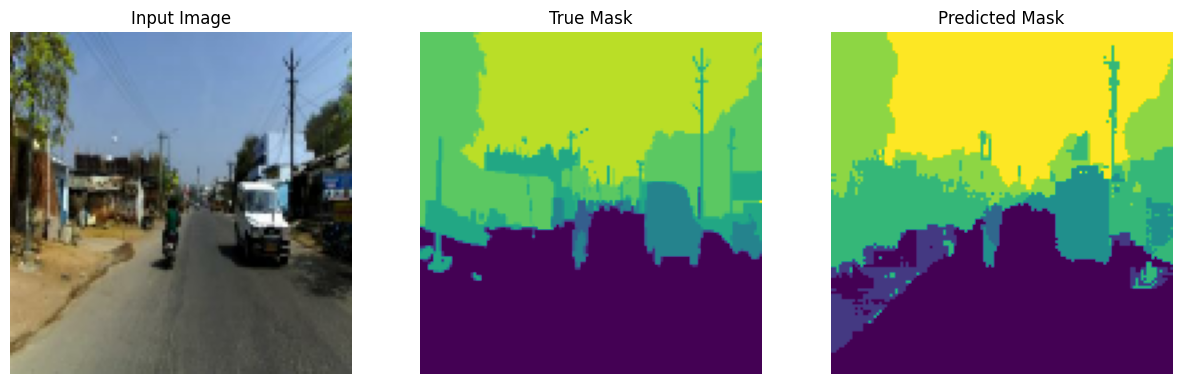

Time Taken : 1.6683430671691895 seconds


In [ ]:
# Calling the predict function
import time
start = time.time()
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/idd20k_lite/leftImg8bit/val/234/frame3334_image.jpg')
end = time.time()
print("Time Taken : "+str(end-start)+" seconds")

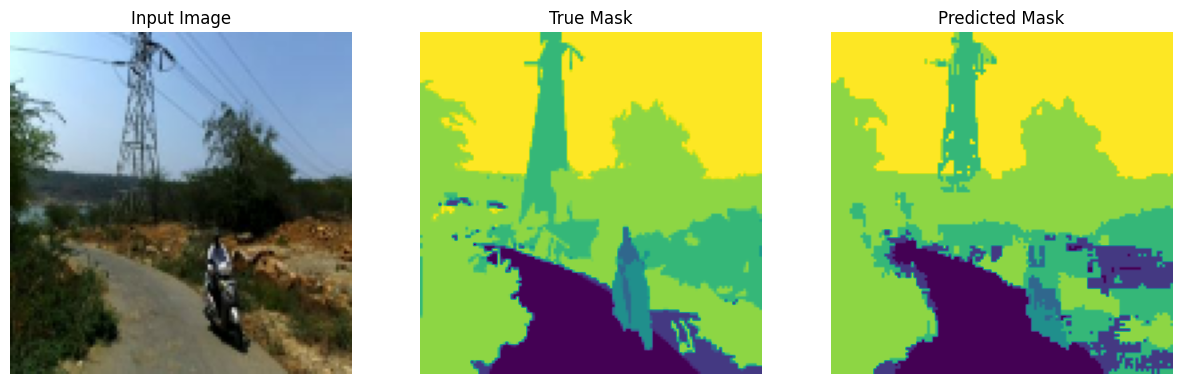

Time Taken : 1.421144962310791 seconds


In [ ]:
start = time.time()
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/idd20k_lite/leftImg8bit/val/328/frame1317_image.jpg')
end = time.time()
print("Time Taken : "+str(end-start)+" seconds")

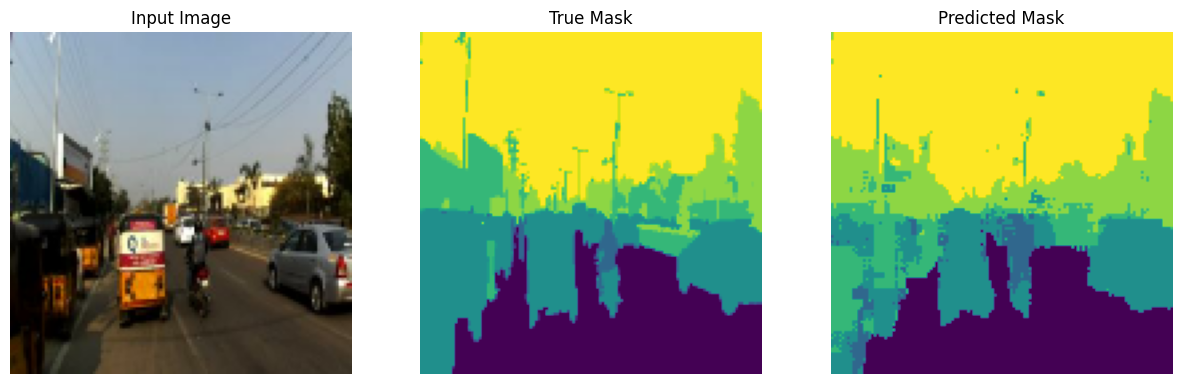

Time Taken : 1.5236730575561523 seconds


In [ ]:
start = time.time()
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/idd20k_lite/leftImg8bit/val/47/000065_image.jpg')
end = time.time()
print("Time Taken : "+str(end-start)+" seconds")

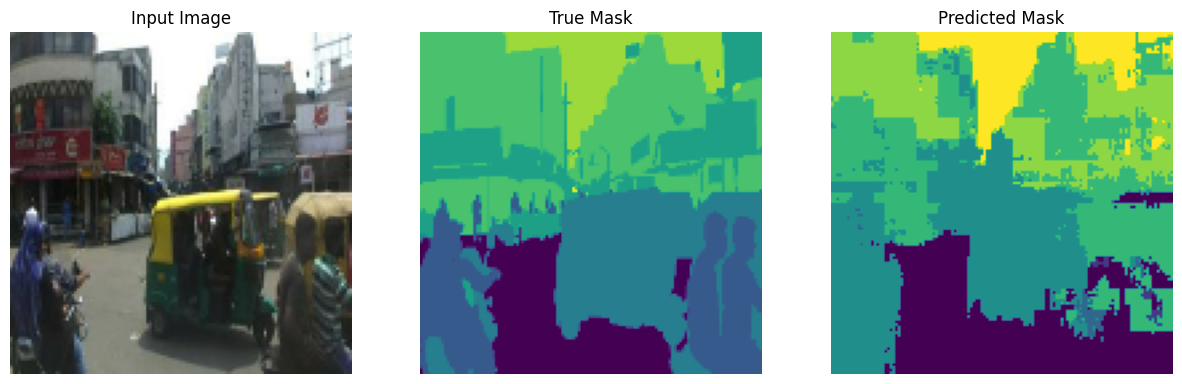

Time Taken : 1.6240167617797852 seconds


In [ ]:
start = time.time()
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/idd20k_lite/leftImg8bit/val/66/831898_image.jpg')
end = time.time()
print("Time Taken : "+str(end-start)+" seconds")

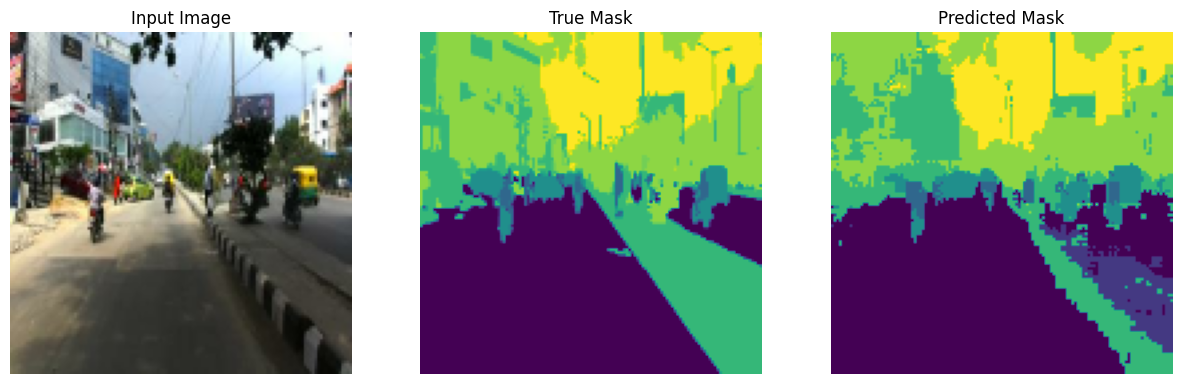

Time Taken : 1.6722500324249268 seconds


In [ ]:
start = time.time()
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/idd20k_lite/leftImg8bit/val/150/290903_image.jpg')
end = time.time()
print("Time Taken : "+str(end-start)+" seconds")

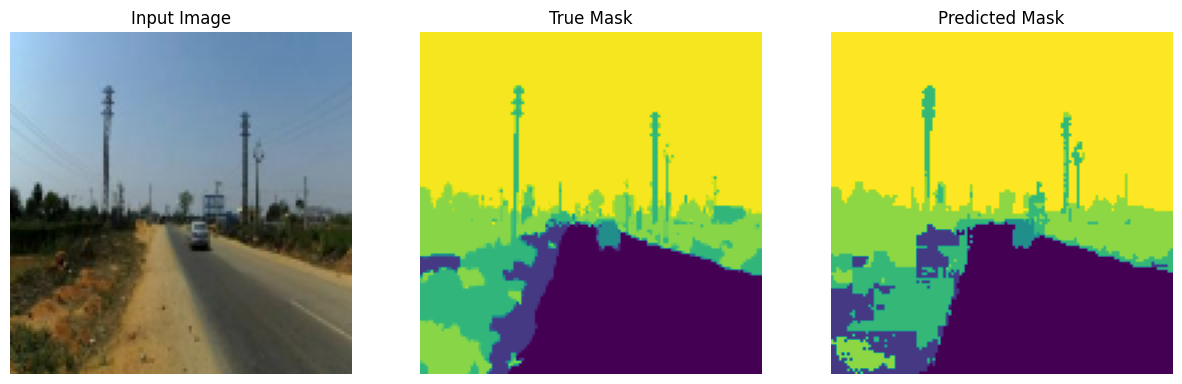

In [ ]:
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/idd20k_lite/leftImg8bit/val/212/frame0011_image.jpg')

In [ ]:
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def IoU(y_i,y_pred):
    # This function calculates the mean Intersection over Union
    # Mean IoU = TP/(FN + TP + FP)
    # This list will save the IoU of all the classes
    IoUs = []
    # Defining the number of classes which the model has predicted
    n_classes = 7
    for c in range(n_classes):
        # Calculating the True Positives
        TP = np.sum((y_i == c)&(y_pred==c))
        # Calculating the False Positives
        FP = np.sum((y_i != c)&(y_pred==c))
        # Calculating the False Negatives
        FN = np.sum((y_i == c)&(y_pred!= c))
        # Calculating the IoU for the particular class
        IoU = TP/float(TP + FP + FN)
        # Printing the outputs
        # Uncomment the print statement below when you want to analyze the results for each class
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        # Appending the IoU to the list as it mean needs to be calculated later
        if(math.isnan(IoU)):
            IoUs.append(0)
            continue
        IoUs.append(IoU)
    # Calculating the mean
    mIoU = np.mean(IoUs)
    #print("_________________")
    # Uncomment this when you want to print the mean IoU
    print("Mean IoU: {:4.3f}".format(mIoU))
    return mIoU

In [ ]:
IoU(true_mask, pred_mask)

class 00: #TP=  3857, #FP=   111, #FN=   31, IoU=0.964
class 01: #TP=   215, #FP=   668, #FN=  415, IoU=0.166
class 02: #TP=     0, #FP=     0, #FN=    0, IoU= nan
class 03: #TP=    54, #FP=    31, #FN=   11, IoU=0.562
class 04: #TP=   640, #FP=   836, #FN=  681, IoU=0.297
class 05: #TP=  1422, #FP=   688, #FN=  390, IoU=0.569
class 06: #TP=  7786, #FP=    76, #FN=   70, IoU=0.982
Mean IoU: 0.506


0.5056760720712835